# Make finger-tapping ROI for experiment 3
Use Neurosynth meta-analysis and AAL atlas to create left and right finger-tapping ROIs in MNI space.

In [1]:
%matplotlib inline
from nilearn.datasets import fetch_atlas_aal
from nilearn import plotting
import nibabel as nib
import numpy as np
from scipy import ndimage

In [2]:
def get_cluster(mat, thresh=0.):
    """
    Return the binarized maximum cluster mask for a statistical map matrix.
    """
    conn_mat = np.ones((3, 3, 3), int)  # 6-connectivity, aka NN1 or "faces"
    binarized = mat > thresh
    binarized = binarized.astype(int)
    
    # If the stat threshold is too high simply return an empty dataframe
    if np.sum(binarized) == 0:
        raise Exception('Attention: No clusters.')

    # Extract connected components above cluster size threshold
    label_map = ndimage.measurements.label(binarized, conn_mat)[0]
    clust_ids = sorted(list(np.unique(label_map)[1:]))
    clust_sizes = [np.sum(label_map==cid) for cid in clust_ids]
    max_clust_idx = clust_sizes.index(max(clust_sizes))
    max_clust_id = clust_ids[max_clust_idx]
    clust_map = label_map == max_clust_id
    return clust_map.astype(int)

In [3]:
aal = fetch_atlas_aal()
aal_img = nib.load(aal['maps'])
aal_map = aal_img.get_data()
l_precentral_idx = int(aal['indices'][aal['labels'].index('Precentral_L')])
r_precentral_idx = int(aal['indices'][aal['labels'].index('Precentral_R')])
l_precentral = aal_map == l_precentral_idx
r_precentral = aal_map == r_precentral_idx

In [4]:
finger_meta = '/Users/tsalo/Downloads/finger_association-test_z_FDR_0.01.nii'
finger_img = nib.load(finger_meta)
finger_map = finger_img.get_data()

# Use conjunction of hemisphere-specific precentral gyrus masks
# and thresholded finger tapping map. Only keep largest cluster,
# when more than one survives
l_finger_clust = np.ones(finger_img.shape)
thresh = 8.
while np.sum(l_finger_clust) > 500:
    thresh_finger_map = finger_map >= thresh
    l_finger = (l_precentral * thresh_finger_map).astype(int)
    l_finger_clust = get_cluster(l_finger)
    thresh += 0.1
print('Left finger image thresholded at {0:.02f} for {1} '
      'voxels'.format(thresh, np.sum(l_finger_clust)))
l_finger_img = nib.Nifti1Image(l_finger_clust, finger_img.affine)

r_finger_clust = np.ones(finger_img.shape)
thresh = 6.
while np.sum(r_finger_clust) > 500:
    thresh_finger_map = finger_map >= thresh
    r_finger = (r_precentral * thresh_finger_map).astype(int)
    r_finger_clust = get_cluster(r_finger)
    thresh += 0.1
print('Right finger image thresholded at {0:.02f} for {1} '
      'voxels'.format(thresh, np.sum(r_finger_clust)))
r_finger_img = nib.Nifti1Image(r_finger_clust, finger_img.affine)

b_finger_img = nib.Nifti1Image(
    l_finger_img.get_data()+r_finger_img.get_data(),
    finger_img.affine)

Left finger image thresholded at 9.60 for 498 voxels
Right finger image thresholded at 7.60 for 490 voxels


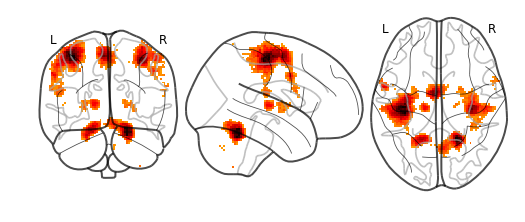

In [5]:
plotting.plot_glass_brain(finger_img, threshold=thresh)

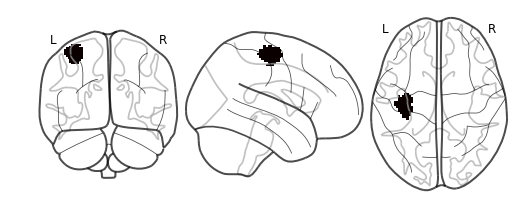

In [6]:
plotting.plot_glass_brain(l_finger_img)
l_finger_img.to_filename('left_finger_ROI.nii.gz')

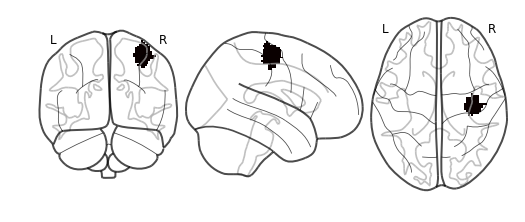

In [7]:
plotting.plot_glass_brain(r_finger_img)
r_finger_img.to_filename('right_finger_ROI.nii.gz')

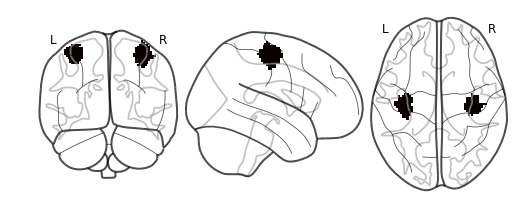

In [8]:
# Just to see them together
plotting.plot_glass_brain(b_finger_img)